In [1]:
import sys
import sklearn
import matplotlib
import numpy as np

print('Python: {}'.format(sys.version))
print('Sklearn: {}'.format(sklearn.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Numpy: {}'.format(np.__version__))

Python: 3.11.2 (tags/v3.11.2:878ead1, Feb  7 2023, 16:38:35) [MSC v.1934 64 bit (AMD64)]
Sklearn: 1.5.0
Matplotlib: 3.8.4
Numpy: 1.24.2


In [3]:
from keras.datasets import mnist

(x_train, y_train), (x_test,y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
print('Training Data:{}'.format(x_train.shape))
print('Training Labels: {}'.format(y_train.shape))

Training Data:(60000, 28, 28)
Training Labels: (60000,)


In [5]:
print('Testing Data: {}'.format(x_test.shape))
print('Testing Label: {}'.format(y_test.shape))

Testing Data: (10000, 28, 28)
Testing Label: (10000,)


In [6]:
import matplotlib.pyplot as plt

# python magic function
%matplotlib inline

C:\Users\Tyler\AppData\Local\Temp\ipykernel_2524\254427469.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


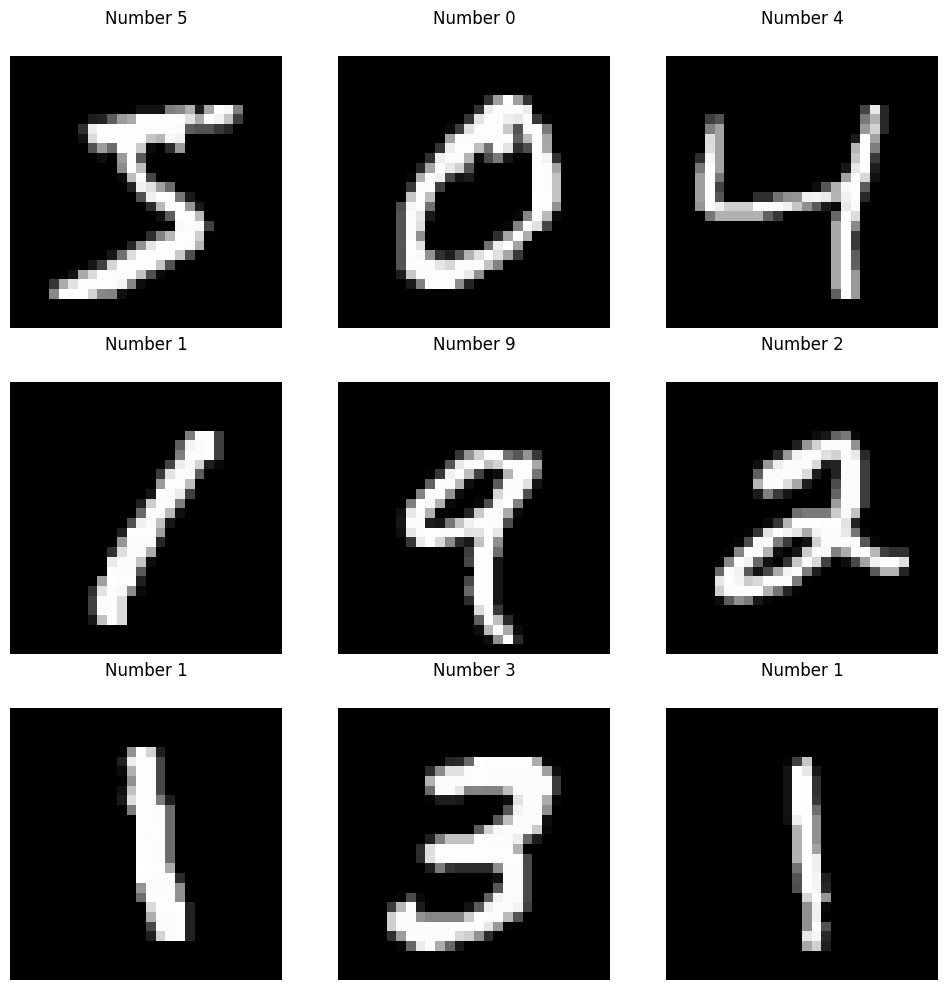

In [8]:
# create figure with 3x3 subplots using plt
fig, axs = plt.subplots(3, 3, figsize = (12,12))
plt.gray()

# loop through the subplots and add mnist images
for i, ax in enumerate(axs.flat):
    ax.matshow(x_train[i])
    ax.axis('off')
    ax.set_title('Number {}'.format(y_train[i]))

fig.show()

In [12]:
# preprocessing the image

#convert each image to 1 dim array
X = x_train.reshape(len(x_train), -1)
Y = y_train

# normalize the data to 0 - 1
X = X.astype(float) / 255.

print(X.shape)
print(X[0].shape)

(60000, 784)
(784,)


In [13]:
from sklearn.cluster import MiniBatchKMeans

n_digits = len(np.unique(y_test))
print(n_digits)

# Initialize KMeans Model
kmeans = MiniBatchKMeans(n_clusters=n_digits)

# Fit the model to the training data
kmeans.fit(X)

10


MiniBatchKMeans(n_clusters=10)

In [14]:
kmeans.labels_[:20]

array([6, 5, 8, 4, 7, 3, 1, 6, 1, 3, 6, 4, 6, 0, 1, 7, 4, 3, 2, 3])

In [28]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each labels
    """

    inferred_labels = {}

    for i in range(kmeans.n_clusters):
        # find the index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this key
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create new array for this key
            inferred_labels[np.argmax(counts)] = [i]

        # print(labels)
        # print('Cluster: {}, Label: {}'.format(i, np.argmax(counts)))
    return inferred_labels

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array. depending on the cluster it has been assigned to
    returns: predicted labels for each array
    """

    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)

    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
    
    return predicted_labels


In [29]:
# info on np.squeeze
array = np.ones((1,3))
print(array.shape)
np.squeeze(array).shape

(1, 3)


(3,)

In [30]:
# test the infer_cluster_labels() and infer_data_labels() functions
cluster_labels = infer_cluster_labels(kmeans,Y)
X_clusters = kmeans.predict(X)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)

print(predicted_labels[:20])
print(Y[:20])

[3 0 4 2 7 8 1 3 1 8 3 2 3 6 1 7 2 8 6 8]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


In [31]:
# optimizing and evaluating the clustering algo

from sklearn import metrics

def calculate_metrics(estimator, data, labels):
    # calculate and print metrics
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    print('Interia: {}'.format(estimator.inertia_))
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, estimator.labels_)))
    

In [33]:
clusters = [10, 16, 36, 64, 144, 256, 400]

# test different numbers of clusters
for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters = n_clusters)
    estimator.fit(X)

    # print cluster metrics
    calculate_metrics(estimator, X, Y)

    # determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, Y)
    predicted_Y = infer_data_labels(estimator.labels_, cluster_labels)

    # calculate and print the accuracy
    print('Accuracy: {}\n'.format(metrics.accuracy_score(Y, predicted_Y)))

Number of Clusters: 10
Interia: 2392290.7252428657
Homogeneity: 0.46349226538094096
Accuracy: 0.5529166666666666

Number of Clusters: 16
Interia: 2210498.2007318703
Homogeneity: 0.5422113288966819
Accuracy: 0.6287333333333334

Number of Clusters: 36
Interia: 1958321.5213062025
Homogeneity: 0.671601627580549
Accuracy: 0.7409

Number of Clusters: 64
Interia: 1812399.039306224
Homogeneity: 0.7376556425396883
Accuracy: 0.8012666666666667

Number of Clusters: 144
Interia: 1620917.4534755533
Homogeneity: 0.8160362648530651
Accuracy: 0.8803833333333333

Number of Clusters: 256
Interia: 1505961.0073692505
Homogeneity: 0.842733287255604
Accuracy: 0.89855

Number of Clusters: 400
Interia: 1420244.793510968
Homogeneity: 0.8677567831449164
Accuracy: 0.91225



In [35]:
# test kmeans algo on testing dataset
# convert each image to 1 dim array
X_test = x_test.reshape(len(x_test),-1)

# normalize the data to 0-1
X_test = X_test.astype(float) / 255.

# initialize and fit kmeans algo on training data
kmeans = MiniBatchKMeans(n_clusters = 400)
kmeans.fit(X)
cluster_labels = infer_cluster_labels(kmeans, Y)

# predicting labels for testing data
test_clusters = kmeans.predict(X_test)
predicted_labels = infer_data_labels(test_clusters, cluster_labels)

# calculate and print accuracy
print('Testing Accuracy: {}'.format(metrics.accuracy_score(y_test,predicted_labels)))


Testing Accuracy: 0.9119


C:\Users\Tyler\AppData\Local\Temp\ipykernel_2524\2706966088.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


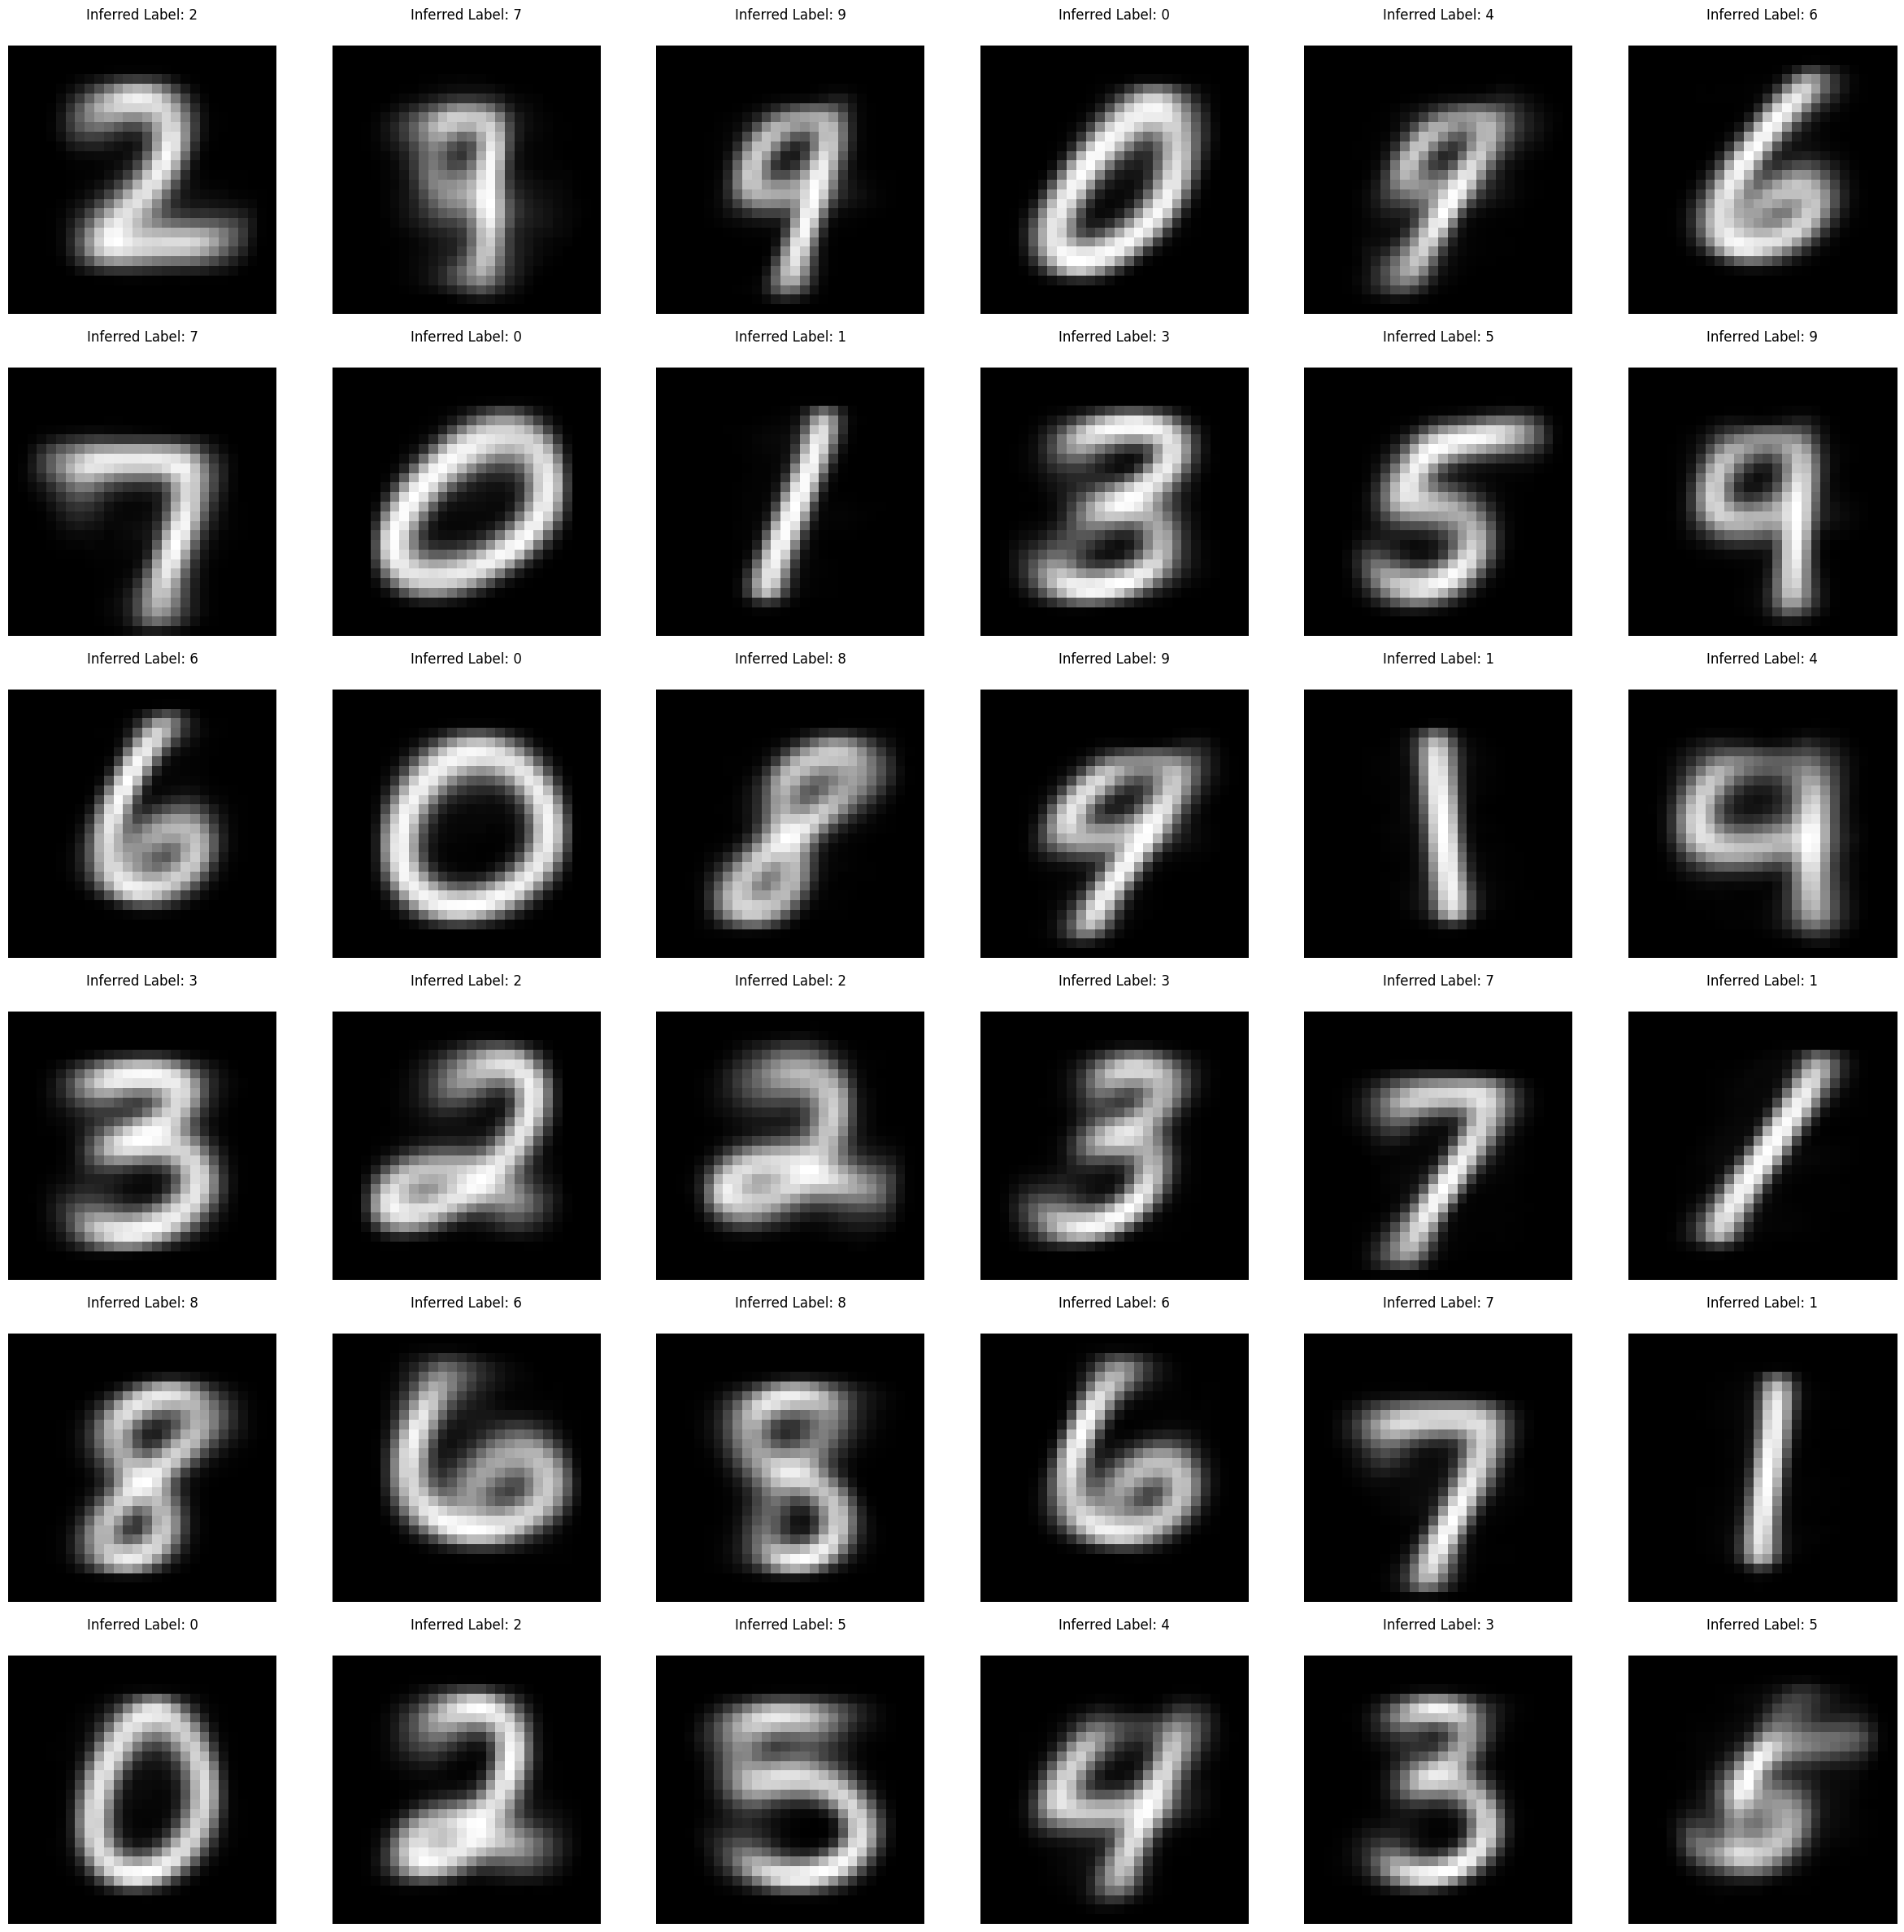

In [47]:
# Visualize cluster centroids

# initialize and fit KMeans algo
kmeans = MiniBatchKMeans(n_clusters = 36)
kmeans.fit(X)

# record centroids value
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(36, 28, 28)
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, Y)

# create fig with subplots using plt
fig, axs = plt.subplots(6, 6, figsize= (30,30))
plt.gray()

# loop through subplots and add centroids images
for i, ax in enumerate(axs.flat):
    # determine inferred labels using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key))

    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')

# display the figure
fig.show()